In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import re
import numpy as np

from collections import Counter

plt.style.use('ggplot')

In [2]:
df = pd.read_csv('tweets.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17410 entries, 0 to 17409
Data columns (total 8 columns):
name              17410 non-null object
username          17410 non-null object
description       14728 non-null object
location          11432 non-null object
followers         17410 non-null int64
numberstatuses    17410 non-null int64
time              17410 non-null object
tweets            17410 non-null object
dtypes: int64(2), object(6)
memory usage: 1.1+ MB


In [4]:
df = df.replace(np.nan, 'missing', regex=True)

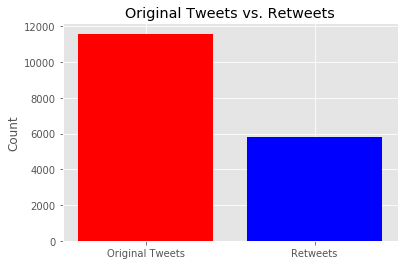

Original:  11584
Retweets:  5826


In [5]:
retweets = []
original_tweets = []

for user, tweet in zip(df['username'], df['tweets']):
    match = re.search(r'^\bRT\b', tweet)
    if match == None:
        original_tweets.append([user,tweet])
    else:
        retweets.append([user,tweet])   

original_tweets = np.array(original_tweets)
retweets = np.array(retweets)

plt.bar([1,2], [len(original_tweets[:,1]), len(retweets[:,1])], align='center', color=['r', 'b'])

ax = plt.gca()
ax.set_ylabel('Count')
ax.set_xticks([1,2])
ax.set_xticklabels(['Original Tweets', 'Retweets'])
ax.set_title('Original Tweets vs. Retweets')

plt.show()

print("Original: ", len(original_tweets[:,1]))
print("Retweets: ", len(retweets[:,1]))

In [6]:
in_set = []
not_in_set = []

for record in original_tweets:
    match = re.findall(r'@\w*', record[1])
    if match != []:
        for name in match:
            if (name[1:] in df['username'].unique()) and (record[0] != name[1:]): 
                in_set.append([record[0], name[1:]]) #sender & receiver appended
            elif record[0] != name[1:]:
                not_in_set.append([record[0], name[1:]]) #sender & receiver appended

in_set = np.array(in_set) 
not_in_set = np.array(not_in_set)

print("Tagged users in set: ", len(np.unique(in_set[:,1])))
print("Tagged users not in set: ", len(np.unique(not_in_set[:,1])))
print("Total users in set: ", len(df['username'].unique()))

Tagged users in set:  41
Tagged users not in set:  1993
Total users in set:  112


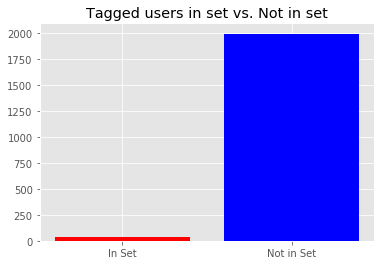

In [7]:
plt.bar([1,2], [len(np.unique(in_set[:,1])), len(np.unique(not_in_set[:,1]))], align='center', color=['r','b'])

labels=['In Set', 'Not in Set']
plt.xticks([1,2], labels)

plt.title('Tagged users in set vs. Not in set')
plt.show()

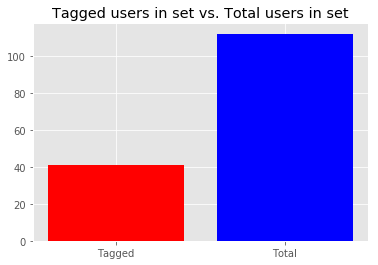

In [8]:
plt.bar([1,2], [len(np.unique(in_set[:,1])), len(df['username'].unique())], align='center', color=['r','b'])

labels=['Tagged', 'Total']
plt.xticks([1,2], labels)

plt.title('Tagged users in set vs. Total users in set')
plt.show()

## Wordcloud of Tweets

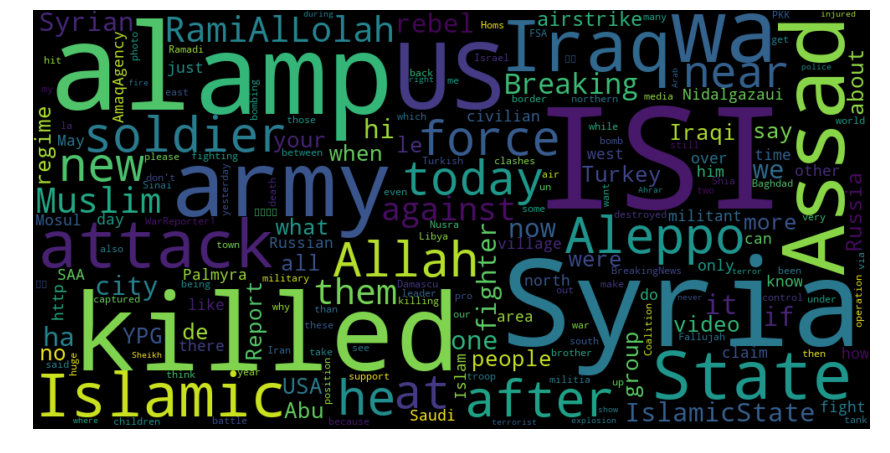

In [9]:
from wordcloud import WordCloud

stopwords = ['https', 'the', 'in', 'to', 'RT', 'is', 'of', 'and', 'you', 'their', 'on', 'that', 'it', 'by', 'with', 'from', 'are', 'for', 'have', 'will', 'they', 'who', 'thi', 'this', 'co', 'be', 'or', 'as', 'so', 'but', 'not', 'an']

wordcloud = WordCloud(width = 1000, height = 500, collocations = False, stopwords=stopwords).generate(' '.join(df['tweets'].tolist()))

plt.figure(figsize=(15,8))

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")

plt.show()

## Worldcloud of pro-ISIS user descriptions

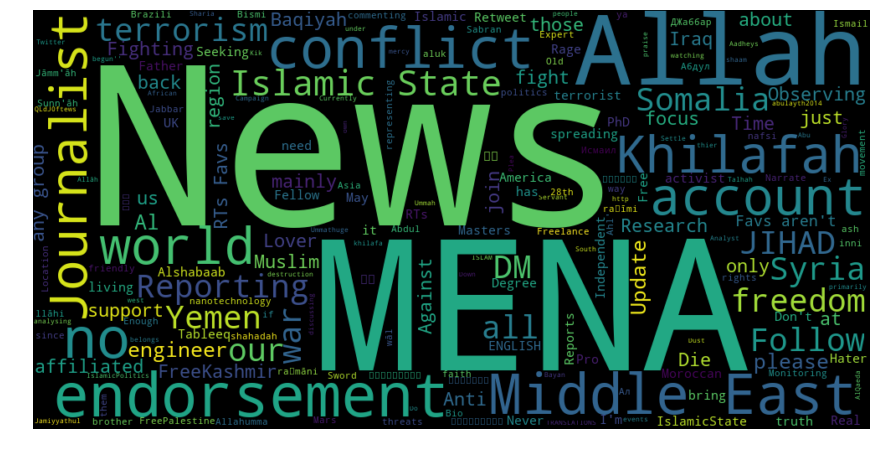

In [10]:
from wordcloud import WordCloud

df1 = df['description'].drop_duplicates()

stopwords = ['https', 'the', 'in', 'to', 'RT', 'is', 'of', 'and', 'you', 'their', 'on', 'that', 'it', 'by', 'with', 'from', 'are', 'for', 'have', 'will', 'they', 'who', 'thi', 'this', 'co', 'be', 'or', 'as', 'so', 'but', 'not', 'an', 'also', 'me', 'we', 'missing', 'My', 'your']

wordcloud = WordCloud(width = 1000, height = 500, stopwords=stopwords).generate(' '.join(df1.tolist()))

plt.figure(figsize=(15,8))

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")

plt.show()

In [11]:
tweeter_tagged = []

for record in original_tweets:
    match = re.findall(r'@\w*', record[1])
    if match != []:
        for name in match:
            tweeter_tagged.append([record[0], name[1:]])

tweeter_tagged = np.array(tweeter_tagged)

## Graph all tweeters listed in the dataset and additional users tagged in a given tweet

In [12]:
graph2 = nx.Graph()

all_users = list(set(tweeter_tagged[:,0]) | set(tweeter_tagged[:,1]))
graph2.add_nodes_from(all_users, count=10)
node_colours = []

for node in graph2.nodes():
    if node in (set(tweeter_tagged[:,0]) & set(tweeter_tagged[:,1])):
        node_colours.append('g') #tweeters & those tagged
    elif node in np.unique(tweeter_tagged[:,0]):
        node_colours.append('r') #only tweeters
    elif node in np.unique(tweeter_tagged[:,1]):
        node_colours.append('b') #only those who were tagged

In [13]:
edges = {}
occurrence_count = Counter(map(tuple, tweeter_tagged))
for (tweeter, tagged), count in occurrence_count.items():
    if (tagged, tweeter) in edges.keys():
        edges[(tagged, tweeter)] = edges[(tagged, tweeter)] + count
    else:
        edges[(tweeter, tagged)] = count
        
for (tweeter, tagged), count in edges.items():
    graph2.add_edge(tweeter, tagged, weight=count)
    
followers2 = {}
tweet_num2 = {}

for username in all_users:
    followers2[username] = df[df['username'] == username]['followers'].unique()
    tweet_num2[username] = df[df['username'] == username]['tweets'].count()

sizes = [(followers2[n] / tweet_num2[n]) * 50 for n in graph2.nodes()]
weights = [graph2.edge[u][v]['weight']/2 for u, v in graph2.edges()]

/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axe

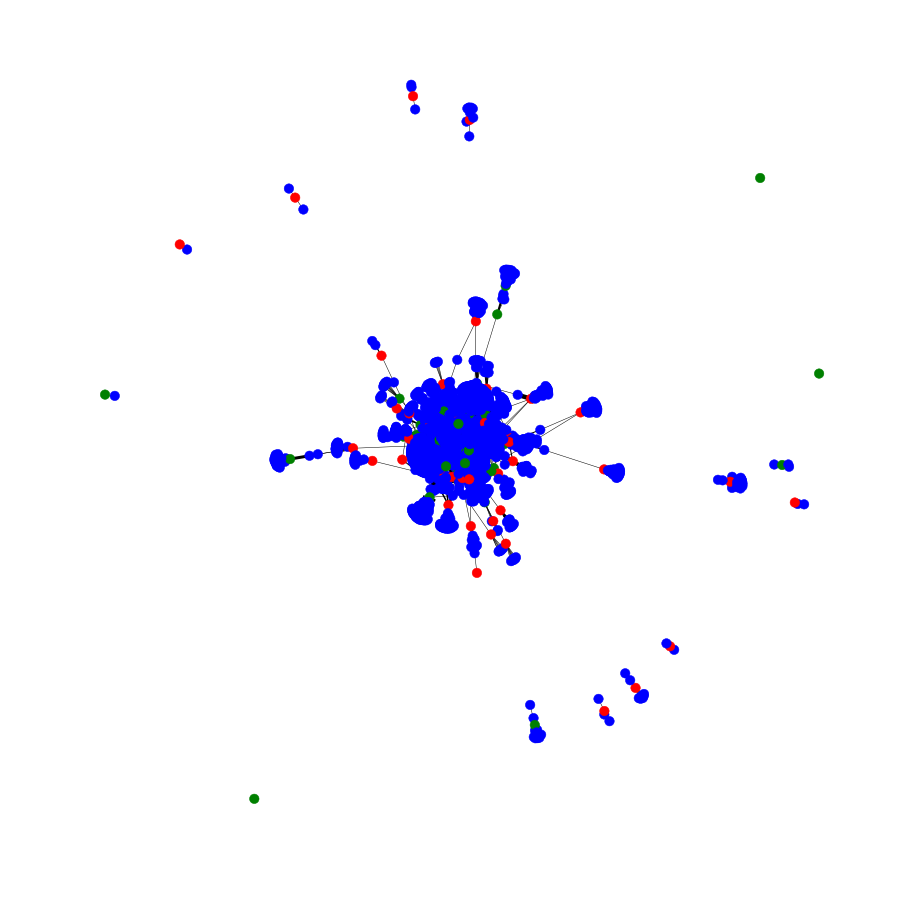

In [14]:
plt.figure(3,figsize=(12,12))

nx.draw(graph2, 
        node_color=node_colours, width=weights, node_size=90)
plt.show()

In [15]:
tweeter_count = Counter(tweeter_tagged[:,0])
tagged_count = Counter(tweeter_tagged[:,1])
top_10_tweeters = tweeter_count.most_common(10)
top_10_tagged = tagged_count.most_common(10)

In [16]:
print("Top 10 Tweeters: ", top_10_tweeters)

Top 10 Tweeters:  [('Uncle_SamCoco', 1179), ('RamiAlLolah', 558), ('MaghrabiArabi', 404), ('melvynlion', 379), ('WarReporter1', 374), ('_IshfaqAhmad', 264), ('warrnews', 185), ('AsimAbuMerjem', 176), ('WhiteCat_7', 140), ('wayf44rerr', 110)]


In [17]:
print("Top 10 Receivers(tagged): ", top_10_tagged)

Top 10 Receivers(tagged):  [('WarReporter1', 131), ('ScotsmanInfidel', 75), ('spicylatte123', 58), ('Ele7vn', 54), ('RamiAlLolah', 53), ('1_texanna', 52), ('sassysassyred', 51), ('kasimf', 48), ('Uncle_SamCoco', 48), ('kafirkaty', 46)]


## Network of Top 10 Tweeters and Top 10 Receivers in relation to each other

/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axe

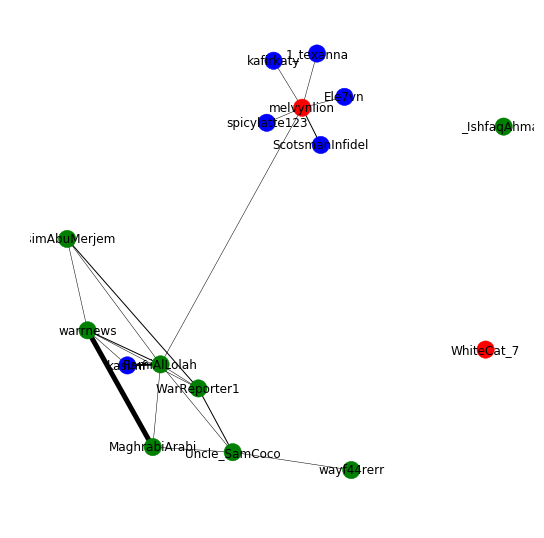

In [18]:
nodes_of_interest = ['Uncle_SamCoco', 'RamiAlLolah', 'MaghrabiArabi', 'melvynlion', 'WarReporter1', '_IshfaqAhmad', 'warrnews', 'AsimAbuMerjem', 'WhiteCat_7', 'wayf44rerr', 'spicylatte123', 'sassysassyrad', 'ScotsmanInfidel', 'Ele7vn', '1_texanna', 'kasimf', 'kafirkaty']  # provided.
        
# Define get_nodes_and_nbrs()
def get_nodes(G, nodes_of_interest):
    """
    Returns a subgraph of the graph `G` with only the `nodes_of_interest` and their neighbors.
    """
    nodes_to_draw = []
    
    # Iterate over the nodes of interest
    for n in nodes_of_interest:
    
        # Append the nodes of interest to nodes_to_draw
        nodes_to_draw.append(n)
        
        # Iterate over all the neighbors of node n
        #for nbr in G.neighbors(n):
        
            # Append the neighbors of n to nodes_to_draw
            #nodes_to_draw.append(nbr)
            
    return G.subgraph(nodes_to_draw)

# Extract the subgraph with the nodes of interest: T_draw
T_draw = get_nodes(graph2, nodes_of_interest)

node_colours1=[]

for node in T_draw.nodes():
    if node in (set(tweeter_tagged[:,0]) & set(tweeter_tagged[:,1])):
        node_colours1.append('g') #tweeters & those tagged
    elif node in np.unique(tweeter_tagged[:,0]):
        node_colours1.append('r') #only tweeters
    elif node in np.unique(tweeter_tagged[:,1]):
        node_colours1.append('b') #only those who were tagged

# Draw the subgraph to the screen
plt.figure(figsize=(7,7))
nx.draw(T_draw, pos=nx.spring_layout(T_draw), node_color=node_colours1, with_labels=True, width=weights)
plt.show()

In [19]:
degrees = [len(graph2.neighbors(n)) for n in graph2.nodes()]
degrees.sort()
print('Top 10 highest degrees: ', degrees[-10:])

Top 10 highest degrees:  [50, 51, 54, 58, 85, 96, 140, 245, 276, 426]


In [20]:
nodes_50_degrees = []

for n in graph2.nodes():
    if len(graph2.neighbors(n)) >= 50:
        nodes_50_degrees.append(n)
        
print(nodes_50_degrees)

['WarReporter1', 'MaghrabiArabi', 'warrnews', 'CXaafada2', 'mobi_ayubi', '_IshfaqAhmad', 'Uncle_SamCoco', 'RamiAlLolah', 'AsimAbuMerjem', 'NaseemAhmed50', 'wayf44rerr']


## Network of individuals connected to 50+ pro-ISIS twitter users in relation to each other

/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axe

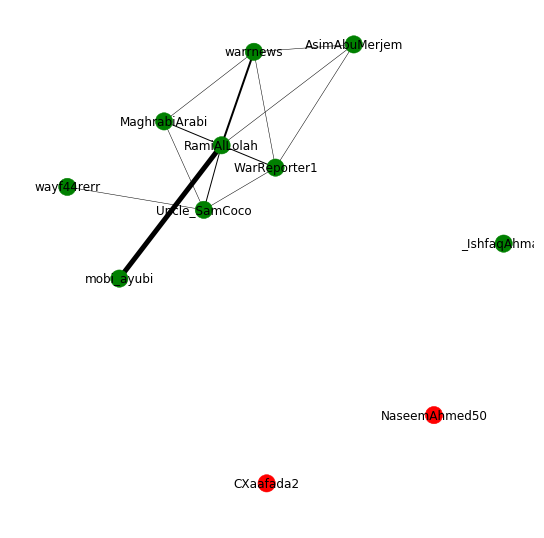

In [39]:
T_draw = get_nodes(graph2, nodes_50_degrees)

node_colours1=[]

for node in T_draw.nodes():
    if node in (set(tweeter_tagged[:,0]) & set(tweeter_tagged[:,1])):
        node_colours1.append('g') #tweeters & those tagged
    elif node in np.unique(tweeter_tagged[:,0]):
        node_colours1.append('r') #only tweeters
    elif node in np.unique(tweeter_tagged[:,1]):
        node_colours1.append('b') #only those who were tagged

# Draw the subgraph to the screen
plt.figure(figsize=(7,7))
nx.draw(T_draw, pos=nx.spring_layout(T_draw), node_color=node_colours1, with_labels=True, width=weights)
plt.show()

## Network of individuals connected to 50+ pro-ISIS twitter users

/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axe

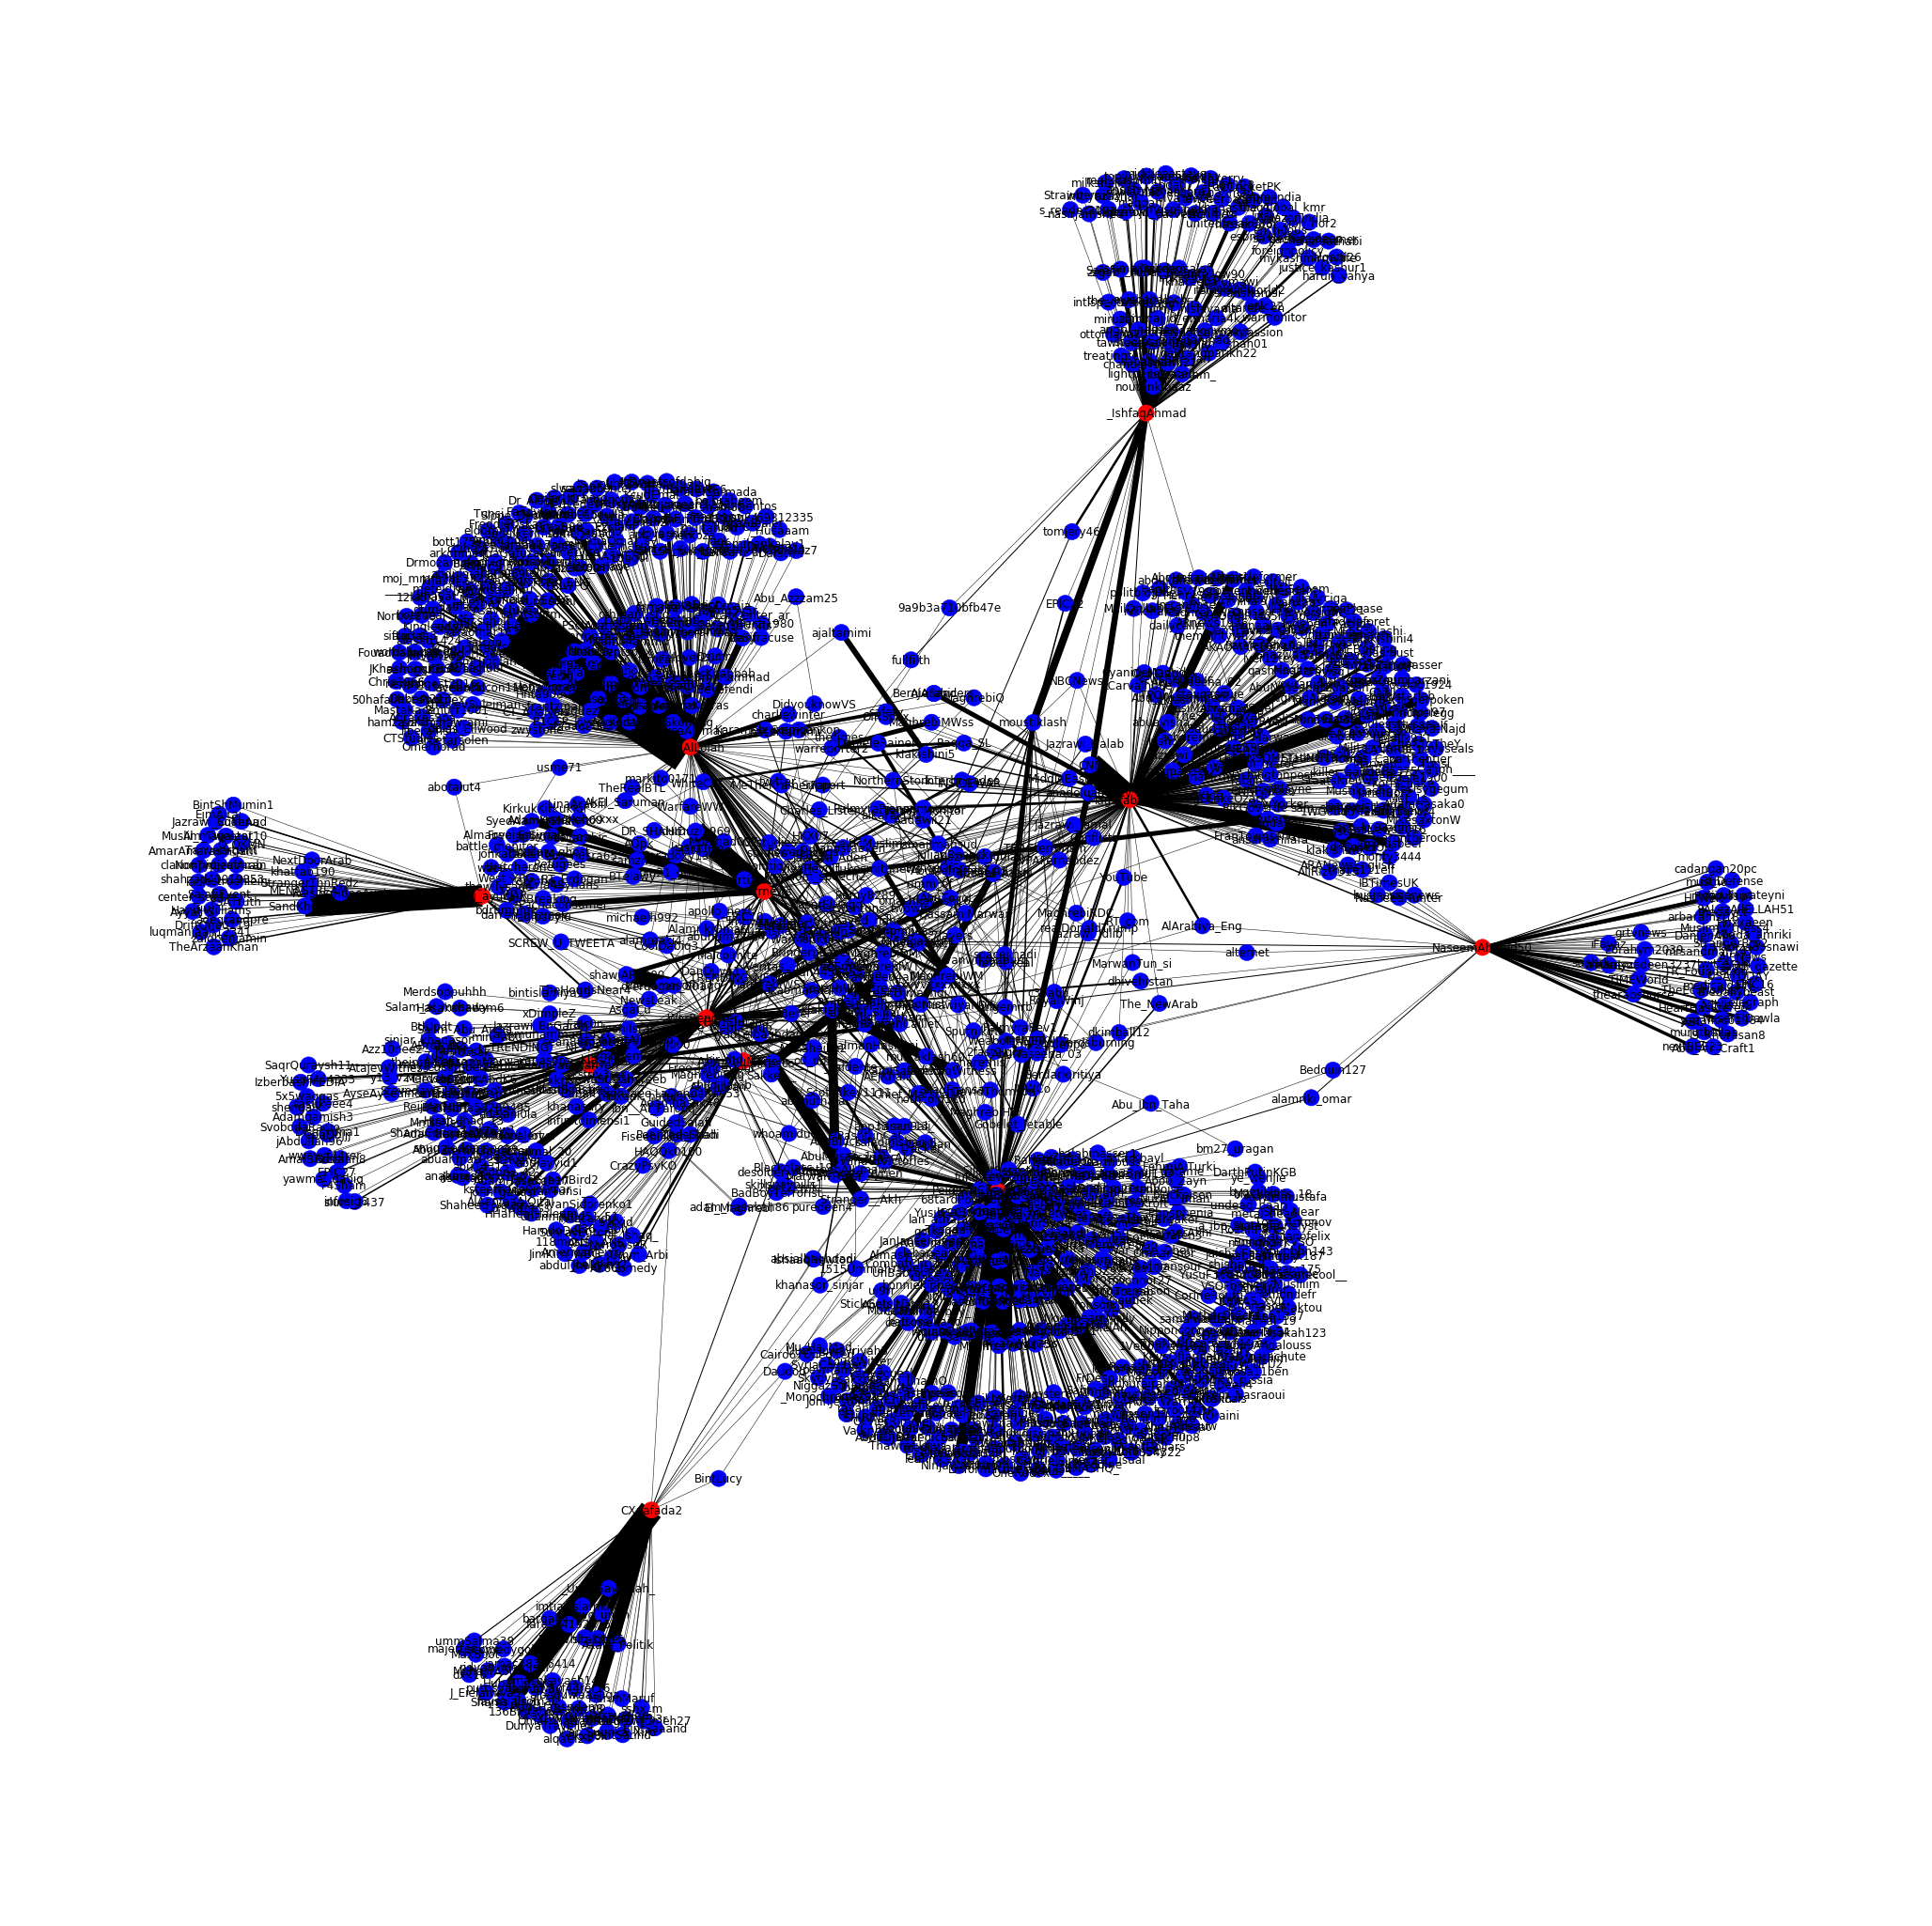

In [22]:
nodes_of_interest = ['RamiAlLolah', 'MaghrabiArabi', 'mobi_ayubi', 'wayf44rerr', 'NaseemAhmed50', 'AsimAbuMerjem', 'Uncle_SamCoco', '_IshfaqAhmad', 'CXaafada2', 'warrnews', 'WarReporter1']
      
# Define get_nodes_and_nbrs()
def get_nodes_and_nbrs(G, nodes_of_interest):
    """
    Returns a subgraph of the graph `G` with only the `nodes_of_interest` and their neighbors.
    """
    nodes_to_draw = []
    
    # Iterate over the nodes of interest
    for n in nodes_of_interest:
    
        # Append the nodes of interest to nodes_to_draw
        nodes_to_draw.append(n)
        
        
        # Iterate over all the neighbors of node n
        for nbr in G.neighbors(n):
        
            # Append the neighbors of n to nodes_to_draw
            nodes_to_draw.append(nbr)
            
    return G.subgraph(nodes_to_draw)

# Extract the subgraph with the nodes of interest: T_draw

T_draw = get_nodes_and_nbrs(graph2, nodes_of_interest)

node_colours1=[]

for node in T_draw.nodes():
    if node in nodes_of_interest:
        node_colours1.append('r') #tweeters & those tagged
    else:
        node_colours1.append('b') #only those who were tagged

# Draw the subgraph to the screen
plt.figure(figsize=(28,28))

nx.draw(T_draw, pos=nx.spring_layout(T_draw), node_color=node_colours1, with_labels=True, width=weights)
plt.show()
#plt.savefig("Graph.png", format="PNG")

## Degree centrality

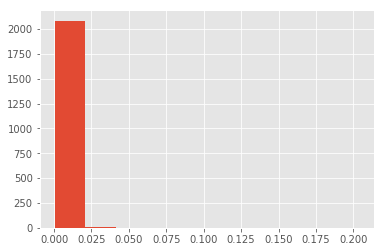

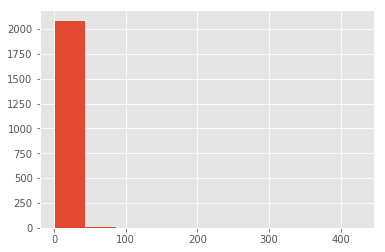

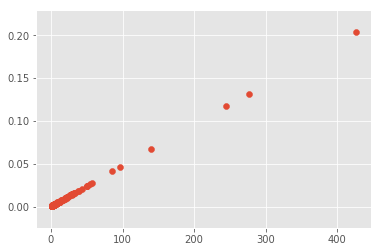

In [23]:
# Import matplotlib.pyplot
import matplotlib.pyplot as plt

# Compute the degree centrality of the Twitter network: deg_cent
deg_cent = nx.degree_centrality(graph2)

# Plot a histogram of the degree centrality distribution of the graph.
plt.figure()
plt.hist(list(deg_cent.values()))
plt.show()

# Plot a histogram of the degree distribution of the graph
plt.figure()
degrees = [len(graph2.neighbors(n)) for n in graph2.nodes()]
plt.hist(degrees)
plt.show()

# Plot a scatter plot of the centrality distribution and the degree distribution
plt.figure()
plt.scatter(x=degrees, y=list(deg_cent.values()))
plt.show()

## Betweenness centrality

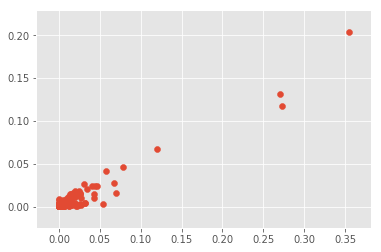

In [24]:
# Compute the betweenness centrality of T: bet_cen
bet_cen = nx.betweenness_centrality(graph2)

# Compute the degree centrality of T: deg_cen
deg_cen = nx.degree_centrality(graph2)

# Create a scatter plot of betweenness centrality and degree centrality
plt.scatter(x=list(bet_cen.values()), y=list(deg_cen.values()))

# Display the plot
plt.show()

## Find node with highest degree centrality

In [25]:
# Define find_nodes_with_highest_deg_cent()
def find_nodes_with_highest_deg_cent(G):

    # Compute the degree centrality of G: deg_cent
    deg_cent = nx.degree_centrality(G)
    
    # Compute the maximum degree centrality: max_dc
    max_dc = max(list(deg_cent.values()))
    
    nodes = set()
    
    # Iterate over the degree centrality dictionary
    for k, v in deg_cent.items():
    
        # Check if the current value has the maximum degree centrality
        if v == max_dc:
        
            # Add the current node to the set of nodes
            nodes.add(k)
            
    return nodes
    
# Find the node(s) that has the highest degree centrality in T: top_dc
top_dc = find_nodes_with_highest_deg_cent(graph2)
print(top_dc)

# Write the assertion statement
for node in top_dc:
    assert nx.degree_centrality(graph2)[node] == max(nx.degree_centrality(graph2).values())

{'Uncle_SamCoco'}


## Find node with highest betweenness centrality

In [26]:
# Define find_node_with_highest_bet_cent()
def find_node_with_highest_bet_cent(G):

    # Compute betweenness centrality: bet_cent
    bet_cent = nx.betweenness_centrality(G)
    
    # Compute maximum betweenness centrality: max_bc
    max_bc = max(list(bet_cent.values()))
    
    nodes = set()
    
    # Iterate over the betweenness centrality dictionary
    for k, v in bet_cent.items():
    
        # Check if the current value has the maximum betweenness centrality
        if v == max_bc:
        
            # Add the current node to the set of nodes
            nodes.add(k)
            
    return nodes

# Use that function to find the node(s) that has the highest betweenness centrality in the network: top_bc
top_bc = find_node_with_highest_bet_cent(graph2)
print(top_bc)

{'Uncle_SamCoco'}


## Calculate maximal cliques

In [27]:
# Calculate the maximal cliques in G: cliques
cliques = nx.find_cliques(graph2)

# Count and print the number of maximal cliques in G
print(len(list(cliques)))

2357


In [28]:
# Define maximal_cliques()
def maximal_cliques(G, size):
    """
    Finds all maximal cliques in graph `G` that are >= size `size`.
    """
    mcs = []
    for clique in nx.find_cliques(G):
        if len(clique) >= size:
            mcs.append(clique)
    return mcs

maximal_cliques(graph2, 5)

[['warrnews', 'RamiAlLolah', 'MaghrabiArabi', 'NorthernStork', 'Nidalgazaui'],
 ['Uncle_SamCoco',
  'MaghrabiArabi',
  'RamiAlLolah',
  'MaghrebiQM',
  'Nidalgazaui']]

## ID top 10 pairs of users

In [29]:
# Import necessary modules
from itertools import combinations
from collections import defaultdict

# Initialize the defaultdict: recommended
recommended = defaultdict(int)

# Iterate over all the nodes in G
for n, d in graph2.nodes(data=True):

    # Iterate over all possible triangle relationship combinations
    for n1, n2 in combinations(graph2.neighbors(n), 2):
    
        # Check whether n1 and n2 do not have an edge
        if not graph2.has_edge(n1, n2):
        
            # Increment recommended
            recommended[(n1, n2)] += 1

# Identify the top 10 pairs of users
all_counts = sorted(recommended.values())
top10_pairs = [pair for pair, count in recommended.items() if count > all_counts[-10]]
print(top10_pairs)


[('QassamiMarwan', 'Uncle_SamCoco'), ('warrnews', 'Uncle_SamCoco'), ('Uncle_SamCoco', 'warrnews'), ('Uncle_SamCoco', 'mobi_ayubi'), ('WarReporter1', 'MaghrabiArabi')]


## ID members with the most followers

In [31]:
df['followers'].describe()

count    17410.000000
mean      3975.076680
std       8674.378495
min         16.000000
25%        266.000000
50%        928.000000
75%       1791.000000
max      34692.000000
Name: followers, dtype: float64

In [58]:
df_most_followers = df.loc[df['followers'] >= 1500]
df_most_followers = df_most_followers.drop_duplicates('username')
df_most_followers = df_most_followers.sort_values('followers')
df_most_followers[['username', 'followers']]

username  followers
5489      _IshfaqAhmad       1520
6392     Uncle_SamCoco       1532
1749     QassamiMarwan       1593
9887      WarReporter1       1748
7095       klakishinki       1791
3113        MaghrebiQM       2021
708      NaseemAhmed50       2121
8634   Freedom_speech2       3233
13076      Nidalgazaui       4187
1878          warrnews       7152
1599       RamiAlLolah      29209

/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axe

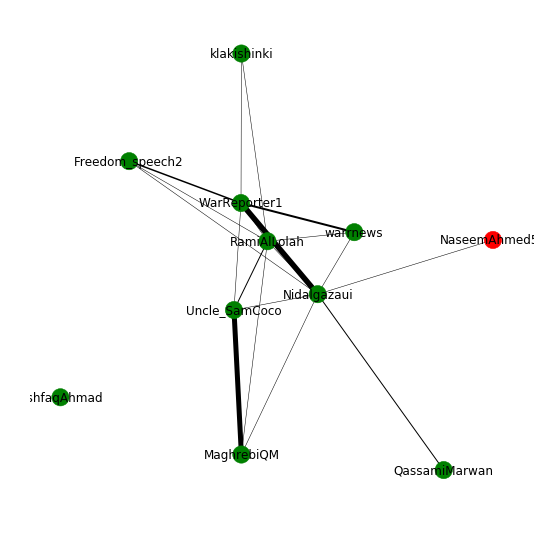

In [50]:
nodes_1500_followers = df_most_followers['username'].tolist()

T_draw = get_nodes(graph2, nodes_1500_followers)

node_colours1=[]

for node in T_draw.nodes():
    if node in (set(tweeter_tagged[:,0]) & set(tweeter_tagged[:,1])):
        node_colours1.append('g') #tweeters & those tagged
    elif node in np.unique(tweeter_tagged[:,0]):
        node_colours1.append('r') #only tweeters
    elif node in np.unique(tweeter_tagged[:,1]):
        node_colours1.append('b') #only those who were tagged

# Draw the subgraph to the screen
plt.figure(figsize=(7,7))
nx.draw(T_draw, pos=nx.spring_layout(T_draw), node_color=node_colours1, with_labels=True, width=weights)
plt.show()

## ID users posting the most tweets

In [60]:
df['numberstatuses'].describe()

count    17410.000000
mean      4760.787651
std       7015.967275
min          1.000000
25%        207.000000
50%        908.000000
75%       6865.000000
max      33091.000000
Name: numberstatuses, dtype: float64

In [61]:
df_most_tweets = df.loc[df['numberstatuses'] >= 6500]
df_most_tweets = df_most_tweets.drop_duplicates('username')
df_most_tweets = df_most_tweets.sort_values('numberstatuses')
df_most_tweets[['username', 'numberstatuses']]

username  numberstatuses
5250          warrnews            6629
1628        mobi_ayubi            6707
15713    Uncle_SamCoco            6743
8634   Freedom_speech2            9180
2104      _IshfaqAhmad           12002
1599       RamiAlLolah           16688
8980       IbnKashmir_           28832
13397           ro34th           32875

/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axe

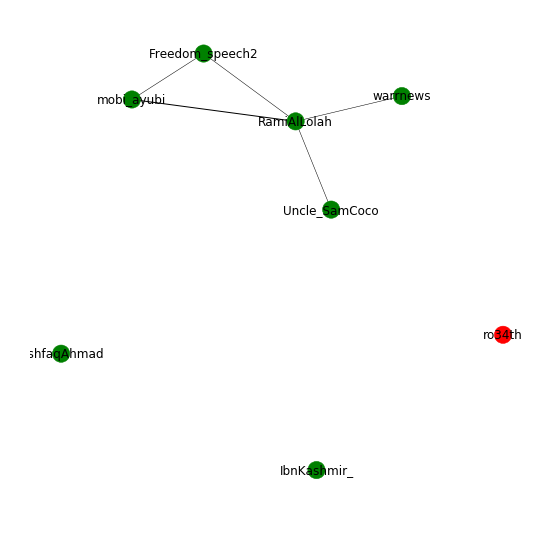

In [62]:
nodes_6500_statuses = df_most_tweets['username'].tolist()

T_draw = get_nodes(graph2, nodes_6500_statuses)

node_colours1=[]

for node in T_draw.nodes():
    if node in (set(tweeter_tagged[:,0]) & set(tweeter_tagged[:,1])):
        node_colours1.append('g') #tweeters & those tagged
    elif node in np.unique(tweeter_tagged[:,0]):
        node_colours1.append('r') #only tweeters
    elif node in np.unique(tweeter_tagged[:,1]):
        node_colours1.append('b') #only those who were tagged

# Draw the subgraph to the screen
plt.figure(figsize=(7,7))
nx.draw(T_draw, pos=nx.spring_layout(T_draw), node_color=node_colours1, with_labels=True, width=weights)
plt.show()

## Most influential pro-ISIS users based on connectedness, number of followers, and number of statuses

In [94]:
nodes_of_interest1 = ['warrnews', 'Uncle_SamCoco', 'Freedom_speech2', '_IshfaqAhmad', 'RamiAlLolah', 'MaghrebiQM', 'WarReporter1', 'NaseemAhmed50']

x=[]

for n in nodes_of_interest1:
    x.append([n, len(graph2.neighbors(n))])
        
df4 = pd.DataFrame(np.array(x).reshape(8,2))

In [93]:
df5 = df.loc[df['username'].isin(nodes_of_interest1)]
df5 = df5.drop_duplicates('username')
df5 = df5[['username', 'followers', 'numberstatuses']]

In [103]:
df6 = df5.merge(df4, left_on='username', right_on=0)
del df6[0]
df6.columns = ['username', 'total followers', 'total statuses', 'total pro-ISIS nodes']
df6 = df6.sort_values('total followers', ascending=False)
df6

username  total followers  total statuses total pro-ISIS nodes
1      RamiAlLolah            29209           16688                  276
2         warrnews             7152            5929                   85
7  Freedom_speech2             3233            9180                   25
0    NaseemAhmed50             2121            4992                   58
3     _IshfaqAhmad             1402           12002                   96
4    Uncle_SamCoco             1273            1820                  426
5       MaghrebiQM              762              61                   38
6     WarReporter1              498             164                  140

/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/Pewelix/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axe

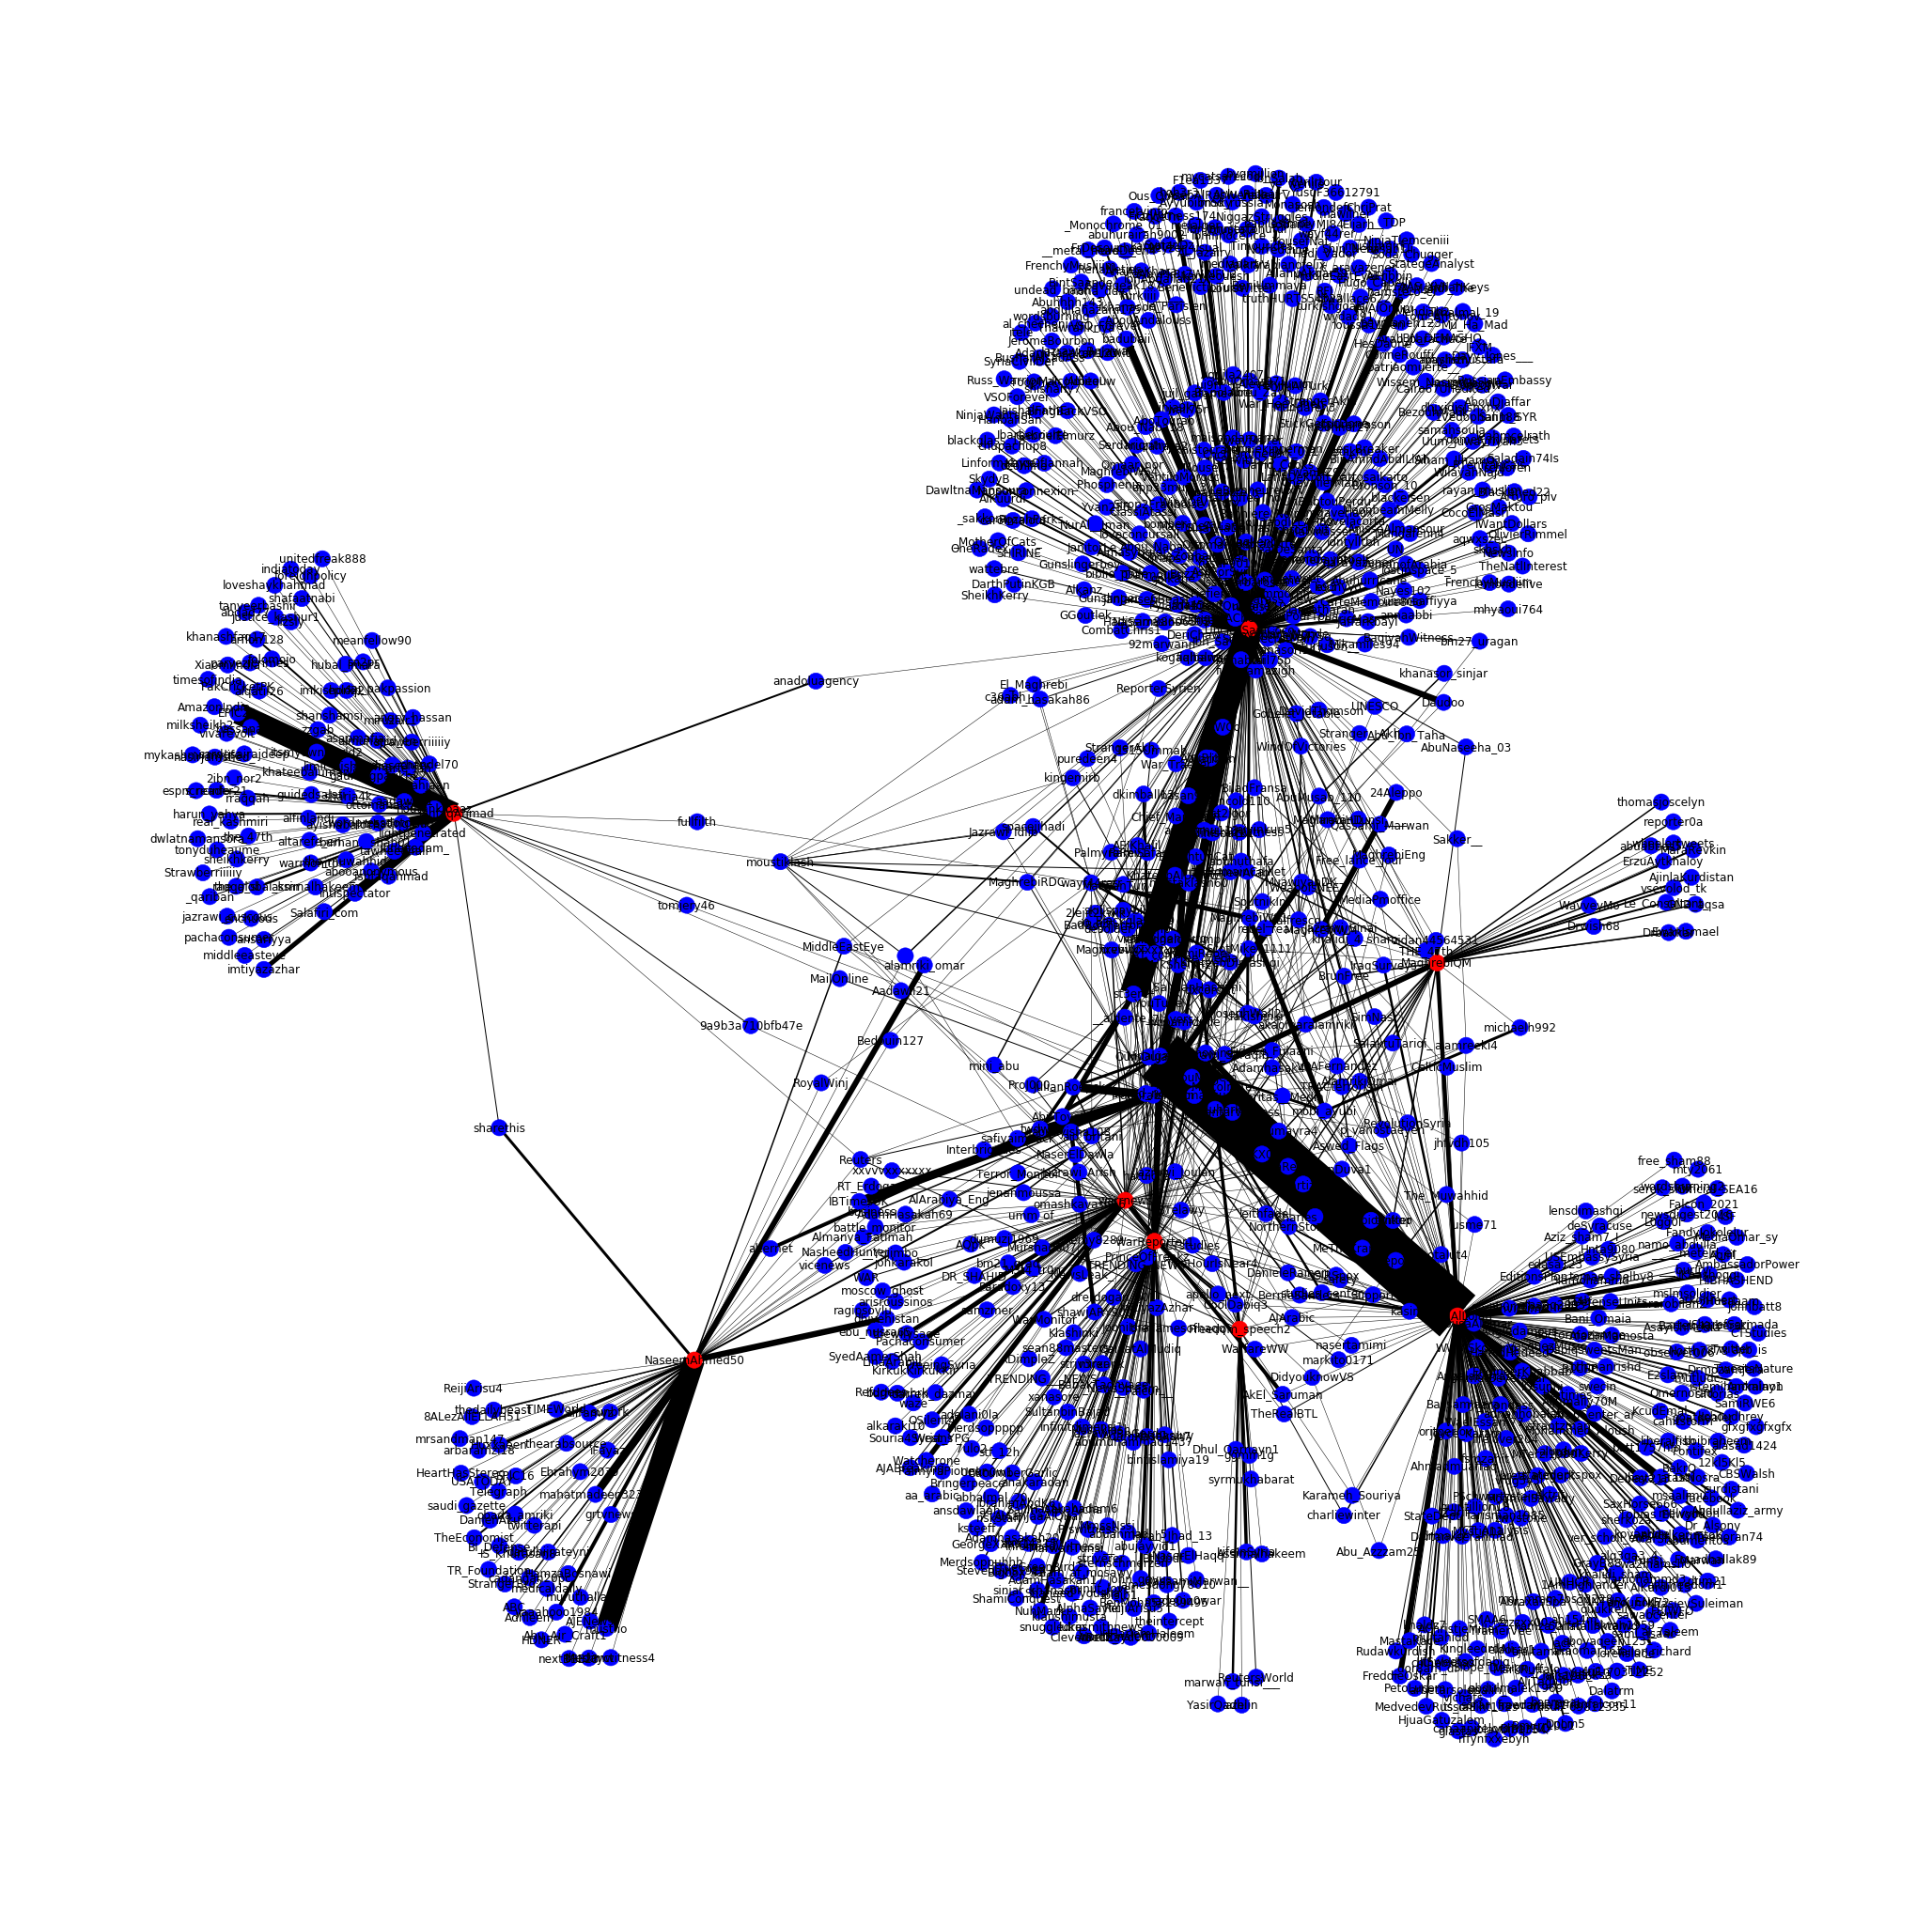

In [104]:
T_draw = get_nodes_and_nbrs(graph2, nodes_of_interest1)

node_colours1=[]

for node in T_draw.nodes():
    if node in nodes_of_interest:
        node_colours1.append('r') #tweeters & those tagged
    else:
        node_colours1.append('b') #only those who were tagged

# Draw the subgraph to the screen
plt.figure(figsize=(28,28))

nx.draw(T_draw, pos=nx.spring_layout(T_draw), node_color=node_colours1, with_labels=True, width=weights)
plt.show()